In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/American\ express/Last\ moment/

/content/drive/My Drive/Colab Notebooks/American express/Last moment


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [0]:
training = pd.read_csv('training.csv')
testing = pd.read_csv('testing.csv')
submission = pd.read_csv('sumbission.csv')

In [71]:
###Over sampling
'''
count_class_0, count_class_1 = training['redemption_status'].value_counts()
dfa = training[training.redemption_status==0]
dfb = training[training.redemption_status==1]
df_class_0_under = dfb.sample(count_class_0,replace =True)
df_test_under = pd.concat([df_class_0_under, dfa], axis=0)
training =df_test_under
'''

"\ncount_class_0, count_class_1 = training['redemption_status'].value_counts()\ndfa = training[training.redemption_status==0]\ndfb = training[training.redemption_status==1]\ndf_class_0_under = dfb.sample(count_class_0,replace =True)\ndf_test_under = pd.concat([df_class_0_under, dfa], axis=0)\ntraining =df_test_under\n"

In [0]:
### Under sampling

count_class_0, count_class_1 = training['redemption_status'].value_counts()
dfa = training[training['redemption_status']==0]
dfb=training[training['redemption_status']==1]
df_class_0_under = dfa.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, dfb], axis=0)
training =df_test_under


In [0]:
idssubmission = submission.pop('id')
idtraining = training.pop('id')
idtesting = testing.pop('id')

In [0]:
### PCA
y_train = training.pop('redemption_status')
y_test = testing.pop('redemption_status')


In [75]:
pca = PCA(svd_solver='randomized', random_state=0)
pca.fit(training)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=0,
    svd_solver='randomized', tol=0.0, whiten=False)

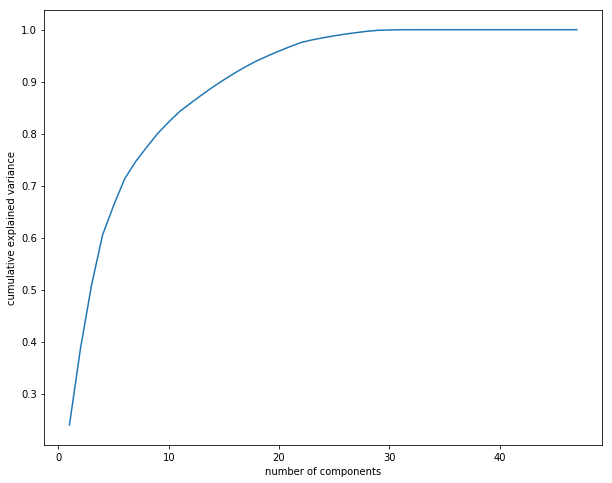

In [76]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (10,8))
plt.plot(range(1,training.shape[1]+1),np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

plt.show()

In [0]:
#Using incremental PCA for efficiency - saves a lot of time on larger datasets
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=25)

In [78]:
X_train_pca = pca_final.fit_transform(training)
X_train_pca.shape

(1444, 25)

In [0]:
### Model

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def roc(y_true, y_pred):
   return metrics.roc_auc_score(y_true, pd.Series(y_pred))
  

In [150]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer with dropout
# Take average of input + output for units/output_dim param in Dense
# input_dim is necessary for the first layer as it was just initialized
classifier.add(Dense(25, input_dim = training.shape[1], kernel_initializer = 'glorot_uniform', activation = 'relu' ))
classifier.add(Dropout(p = 0.1))

# Adding the second hidden layer with dropout
# doesn't need the input_dim params
# kernel_initializer updates weights
# activation function - rectifier
classifier.add(Dense(15, kernel_initializer = 'glorot_uniform', activation = 'relu' ))
classifier.add(Dropout(p = 0.1))

# Adding the output layer
# dependent variable with more than two categories (3), output_dim needs to change (e.g. 3), activation function - sufmax
classifier.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid' ))

# Compiling the ANN - applying Stochastic Gradient Descent to whole ANN
# Several different SGD algorithms
# mathematical details based on the loss function
# binary_crossentropy, categorical_cross_entropy
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [f1_m])

# Fitting the ANN to the Training Set
# X_train, y_train, Batch size, Epochs (whole training set)
classifier.fit(training, y_train,validation_data=(testing,y_test), batch_size = 10, nb_epoch = 100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1444 samples, validate on 784 samples
Epoch 1/100
1444/1444 [==============================] - 1s 808us/step - loss: 0.6756 - f1_m: 0.5694 - val_loss: 0.6272 - val_f1_m: 0.0287
Epoch 2/100
1444/1444 [==============================] - 0s 210us/step - loss: 0.5985 - f1_m: 0.6721 - val_loss: 0.5440 - val_f1_m: 0.0300
Epoch 3/100
1444/1444 [==============================] - 0s 201us/step - loss: 0.5601 - f1_m: 0.6958 - val_loss: 0.5147 - val_f1_m: 0.0306
Epoch 4/100
1444/1444 [==============================] - 0s 210us/step - loss: 0.5357 - f1_m: 0.7145 - val_loss: 0.5438 - val_f1_m: 0.0287
Epoch 5/100
1444/1444 [==============================] - 0s 205us/step - loss: 0.5090 - f1_m: 0.7324 - val_loss: 0.4864 - val_f1_m: 0.0442
Epoch 6/100
1444/1444 [==============================] - 0s 213us/step - loss: 0.5044 - f1_m: 0.7416 - val_loss: 0.4825 - val_f1_m: 0.0429
Epoch 7/100
1444/1444 [==============================] - 0s 223us/step - loss: 0.4917 - f1_m: 0.7363 - val_loss: 0.4949

In [0]:
##lrmodel = LogisticRegression(penalty='l1')
##lrmodel.fit(X_train_pca,y_train)

In [0]:
lrmodel = classifier
train_pred_1 = lrmodel.predict(training)

train_pred = [1 if x>0.5 else 0 for x in train_pred_1]

In [153]:
accuracy_score = metrics.accuracy_score(y_train, train_pred)
precision_score = metrics.precision_score(y_train, train_pred)
recall_score = metrics.recall_score(y_train, train_pred)
f1_score = metrics.f1_score(y_train, train_pred)
roc = metrics.roc_auc_score(y_train, train_pred)
# print(accuracy_score, precision_score, recall_score, f1_score)


# write the scores into the output file as a dictionary
# this code is already written for you
d = {'recall_score': recall_score,
    'f1_score': f1_score,
    'accuracy_score': accuracy_score,
	'precision_score': precision_score,
    'ROC' :roc}
for key,val in d.items():
    print(key,'  :  ',val)

recall_score   :   0.9653739612188366
f1_score   :   0.9159001314060446
accuracy_score   :   0.9113573407202216
precision_score   :   0.87125
ROC   :   0.9113573407202217


In [154]:
X_test_pca = pca_final.transform(testing)
X_test_pca.shape

(784, 25)

In [0]:
test_pred_1 = lrmodel.predict(testing)

test_pred = [1 if x>0.5 else 0 for x in test_pred_1]

In [156]:
accuracy_score = metrics.accuracy_score(y_test, test_pred)
precision_score = metrics.precision_score(y_test, test_pred)
recall_score = metrics.recall_score(y_test, test_pred)
f1_score = metrics.f1_score(y_test, test_pred)
roc = metrics.roc_auc_score(y_test, test_pred)
# print(accuracy_score, precision_score, recall_score, f1_score)


# write the scores into the output file as a dictionary
# this code is already written for you
d = {'recall_score': recall_score,
    'f1_score': f1_score,
    'accuracy_score': accuracy_score,
	'precision_score': precision_score,
    'ROC' :roc}
for key,val in d.items():
    print(key,'  :  ',val)

recall_score   :   1.0
f1_score   :   0.0693069306930693
accuracy_score   :   0.7602040816326531
precision_score   :   0.035897435897435895
ROC   :   0.879021879021879


In [157]:
X_test_pca_final = pca_final.transform(submission)
X_test_pca_final.shape

(50226, 25)

In [0]:
test_pred_final_1 = lrmodel.predict(submission)

test_pred_final = [1 if x>0.5 else 0 for x in test_pred_final_1]

In [0]:
dfcheck  =  pd.DataFrame(test_pred_final,idssubmission)

In [0]:
dfcheck.columns = ['redemption_status']

In [0]:
dfcheck.to_csv('Answers.csv')

In [0]:
from google.colab import files
files.download('Answers.csv') 